# Learning to learn on a simple linear regression problem

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tqdm import tqdm
import sklearn.metrics as sm
import pandas as pd

## Define data for our example

The values function we are trying to learn is *y = 3x + 2 + some noise* 

In [2]:
TRUE_a = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 300

xs  = tf.random.normal(shape=[NUM_EXAMPLES])

noise = np.random.normal(0, .1, xs.shape)

ys = (TRUE_a * xs) + TRUE_b + noise

In [6]:
train_x, test_x, valid_x, train_y, test_y, valid_y = xs[:200], xs[200:250], xs[250:], ys[:200], ys[200:250], ys[250:]

### Specify LSTM optimizer params

In [3]:
n_dimension = 2
normal_init = tf.random_uniform_initializer(minval=-0.01, maxval=0.05, seed=None)
batch_size = 1
num_unroll = 20 
hidden_size = 20
num_layers = 2
epochs = 50

In [7]:
val_accuracy = sm.mean_squared_error
loss_object = tf.keras.losses.MeanSquaredError()

## Define Optimizee model

In [76]:
class Optimizee(Model):
    def __init__(self):
        super(Optimizee, self).__init__()
        self.a = tf.Variable(initial_value = normal_init(shape=(1, 1), dtype='float'), trainable=True)
        self.b = tf.Variable(initial_value = normal_init(shape=(1, 1), dtype='float'), trainable=True)
        self.training_losses, self.validation_losses, self.list_a, self.list_b = [], [], [], []
        self.tensor_trainable_weights = self.trainable_weights
 
    def call(self, W, tensor_trainable_weights):
        return W * tensor_trainable_weights[0] + tensor_trainable_weights[1] 

In [85]:
  
def train(X_train, y_train, epochs=100, for_optimizer=False):
    for epoch in range(epochs):
        loss, valid_loss, valid_accuracy = train_data_for_one_epoch(for_optimizer)
        model.training_losses.append(loss.numpy())
        print("Epoch: {} , training loss: {}, val loss: {}, val MSE accuracy {}".format(
            epoch, loss, valid_loss, valid_accuracy, 4
        ))

def train_data_for_one_epoch(for_optimizer):
    # Keep track of predictions     
    model.list_a.append(model.tensor_trainable_weights[0])
    model.list_b.append(model.tensor_trainable_weights[1])
    if for_optimizer:
      loss = apply_optimizer_gradient(xs, ys)
    else:
      loss = apply_gradient(xs, ys)
    loss = loss / num_unroll
    
    # validation dataset
    validation_predictions = model(valid_x, model.tensor_trainable_weights)
    validation_predictions = tf.squeeze(validation_predictions)
    
    validation_loss = loss_object(y_true=valid_y, y_pred=validation_predictions)
    validation_accuracy = val_accuracy(y_true=valid_y, y_pred=validation_predictions)
    model.validation_losses.append(validation_loss)
    
    return loss, validation_loss, validation_accuracy

def apply_optimizer_gradient(x, y):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0
    
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch([model.tensor_trainable_weights])
                predictions = model(x, model.tensor_trainable_weights)
                loss_value = loss_object(y_true=y, y_pred=predictions)
                loss += loss_value
                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = model.tensor_trainable_weights + lstm_optimizer_results

        lstm_gradients = tape_master.gradient(loss, LSTM_optimizer.trainable_variables)
    
    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    return loss

def apply_gradient(x, y):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0
    
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch([model.tensor_trainable_weights])
                predictions = model(x, model.tensor_trainable_weights)
                loss_value = loss_object(y_true=y, y_pred=predictions)
                loss += loss_value
                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = model.tensor_trainable_weights + lstm_optimizer_results

    return loss

## Define LSTM Optimizer

In [95]:
class LSTMOptimizer(Model):
    def __init__(self, hidden_size, num_layers, n_dimension, batch_size, num_unroll, **kwargs):
        super().__init__(**kwargs)
        # dense layer to convert the lstm cell output to coordinatewise parameter update
        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.batch_size = batch_size
        self.lstm_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size) for _ in range(num_layers)])
        self.state = self.lstm_cells.get_initial_state(batch_size = self.batch_size, dtype = 'float') 
        self.num_unroll = num_unroll
        
    def refresh_state(self):
        self.state = self.lstm_cells.get_initial_state(batch_size = self.batch_size, dtype = 'float') 
    
    def call(self, grad_f):
        gradient_updates_list = []
        for i in range(n_dimension):
            current_gradient = grad_f[i] # The gradient of the i-th parameter of current gradients of function f
            cell_output, state = self.lstm_cells(current_gradient, self.state) 
            self.state = state 
            parameter_update = self.dense(cell_output)
            gradient_updates_list.append(parameter_update)

        gradient_updates_list = tf.reshape(gradient_updates_list, shape=[2,1,1])

        return gradient_updates_list

### Initialize optimizee and optimizer

In [99]:
LSTM_optimizer = LSTMOptimizer(hidden_size=hidden_size, num_layers=num_layers, n_dimension=n_dimension, batch_size=batch_size, num_unroll=num_unroll)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [100]:
model = Optimizee()

## Train optimizer

In [101]:
train(train_x, train_y, epochs, for_optimizer=True)

Epoch: 0 , training loss: 3.345646619796753, val loss: 0.7034501433372498, val MSE accuracy 0.703450083732605
Epoch: 1 , training loss: 0.371705561876297, val loss: 0.33796730637550354, val MSE accuracy 0.33796730637550354
Epoch: 2 , training loss: 0.23461957275867462, val loss: 0.23210783302783966, val MSE accuracy 0.23210783302783966
Epoch: 3 , training loss: 0.15987089276313782, val loss: 0.16123047471046448, val MSE accuracy 0.16123047471046448
Epoch: 4 , training loss: 0.11078734695911407, val loss: 0.11310229450464249, val MSE accuracy 0.11310230195522308
Epoch: 5 , training loss: 0.07760848104953766, val loss: 0.08049216866493225, val MSE accuracy 0.08049216866493225
Epoch: 6 , training loss: 0.055388111621141434, val loss: 0.0584699772298336, val MSE accuracy 0.0584699772298336
Epoch: 7 , training loss: 0.04055430740118027, val loss: 0.04361927509307861, val MSE accuracy 0.043619271367788315
Epoch: 8 , training loss: 0.030685454607009888, val loss: 0.033610206097364426, val MSE

### Train model with trained optimizer

In [103]:
model = Optimizee()

In [105]:
train(train_x, train_y, epochs, for_optimizer=False)

Epoch: 0 , training loss: 3.21947979927063, val loss: 0.6641342639923096, val MSE accuracy 0.6641343832015991
Epoch: 1 , training loss: 0.37694329023361206, val loss: 0.35123154520988464, val MSE accuracy 0.35123154520988464
Epoch: 2 , training loss: 0.2420051097869873, val loss: 0.23747439682483673, val MSE accuracy 0.23747442662715912
Epoch: 3 , training loss: 0.16227269172668457, val loss: 0.16227401793003082, val MSE accuracy 0.16227401793003082
Epoch: 4 , training loss: 0.11074398458003998, val loss: 0.11228176951408386, val MSE accuracy 0.11228176206350327
Epoch: 5 , training loss: 0.07658864557743073, val loss: 0.07899937778711319, val MSE accuracy 0.07899937778711319
Epoch: 6 , training loss: 0.05411512777209282, val loss: 0.0568881519138813, val MSE accuracy 0.0568881519138813
Epoch: 7 , training loss: 0.039351679384708405, val loss: 0.0421951487660408, val MSE accuracy 0.0421951487660408
Epoch: 8 , training loss: 0.029673079028725624, val loss: 0.032423410564661026, val MSE a

### Plot initial data from Model trained using LSTM 

In [106]:
list_a = tf.reshape(model.list_a, [epochs])
list_b = tf.reshape(model.list_b, [epochs])

In [107]:
def plot_data(inputs, outputs, predicted_outputs):
    real = plt.scatter(inputs, outputs, c='b', marker='.')
    predicted = plt.scatter(inputs, predicted_outputs, c='r', marker='+')
    plt.legend((real,predicted), ('Real Data', 'Predicted Data'))
    plt.show()

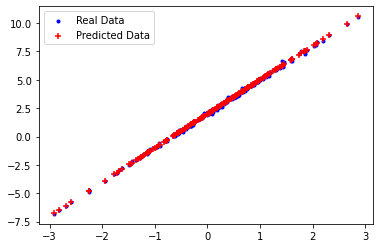

Current loss: 0.011491


In [108]:
plot_data(train_x, train_y, model(train_x, model.tensor_trainable_weights))
print('Current loss: %1.6f' % loss_object(model(xs, model.tensor_trainable_weights), ys).numpy())

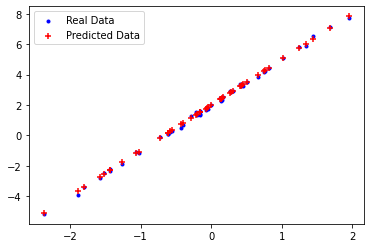

Current test data loss: 0.011491


In [109]:
plot_data(test_x, test_y, model(test_x, model.tensor_trainable_weights))
print('Current test data loss: %1.6f' % loss_object(model(xs, model.tensor_trainable_weights), ys).numpy())

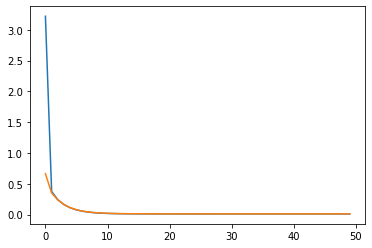

In [110]:
plt.plot(model.training_losses)
plt.plot(model.validation_losses)

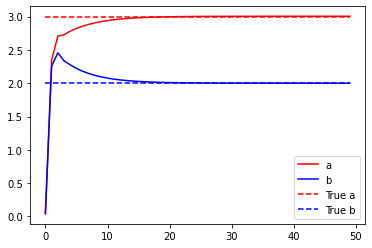

In [111]:
plt.plot(list_a, 'r',
       list_b, 'b')
plt.plot([TRUE_a] * epochs, 'r--',
      [TRUE_b] * epochs, 'b--')
plt.legend(['a', 'b', 'True a', 'True b'])
plt.show()

## Hand Crafted Optimizers Train and Test

In [112]:
class NormalModel(Model):
    def __init__(self):
        super(NormalModel, self).__init__()
        self.a = tf.Variable(initial_value = normal_init(shape=(1, 1), dtype='float'), trainable=True)
        self.b = tf.Variable(initial_value = normal_init(shape=(1, 1), dtype='float'), trainable=True)
 
    def call(self, W):
        return self.a * W + self.b

In [113]:
adam_model = NormalModel()
adam_model.compile(optimizer='adam', loss='mean_squared_error')
adam_history = adam_model.fit(xs, ys, epochs=epochs, validation_data=(valid_x, valid_y))

rmsprop_model = NormalModel()
rmsprop_model.compile(optimizer='rmsprop', loss='mean_squared_error')
rms_prop_history = rmsprop_model.fit(xs, ys, epochs=epochs, validation_data=(valid_x, valid_y))

sgd_model = NormalModel()
sgd_model.compile(optimizer='sgd', loss='mean_squared_error')
sgd_history = sgd_model.fit(xs, ys, epochs=epochs, validation_data=(valid_x, valid_y))

adagrad_model = NormalModel()
adagrad_model.compile(optimizer='adagrad', loss='mean_squared_error')
adagrad_history = adagrad_model.fit(xs, ys, epochs=epochs, validation_data=(valid_x, valid_y))

Epoch 1/50
10/10 [==============================] - 1s 27ms/step - loss: 15.4365 - val_loss: 15.1376
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 15.9726 - val_loss: 15.0294
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 14.6866 - val_loss: 14.9199
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 15.2029 - val_loss: 14.8100
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 14.2820 - val_loss: 14.7030
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 12.8906 - val_loss: 14.6007
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 14.2668 - val_loss: 14.4924
Epoch 8/50
10/10 [==============================] - 0s 7ms/step - loss: 14.0491 - val_loss: 14.3861
Epoch 9/50
10/10 [==============================] - 0s 7ms/step - loss: 13.8468 - val_loss: 14.2776
Epoch 10/50
10/10 [==============================] - 0s 8ms/step - loss: 14.5794 - val_loss: 14.171

# Plot losses and compare results

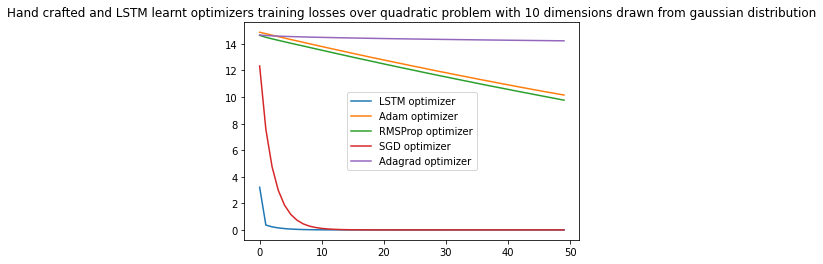

In [114]:
# plt.plot(model.training_losses)
plt.plot(model.training_losses, label='LSTM optimizer')
plt.plot(adam_history.history['loss'], label='Adam optimizer')
plt.plot(rms_prop_history.history['loss'], label='RMSProp optimizer')
plt.plot(sgd_history.history['loss'], label='SGD optimizer')
plt.plot(adagrad_history.history['loss'], label='Adagrad optimizer')

plt.title('Hand crafted and LSTM learnt optimizers training losses over quadratic problem with 10 dimensions drawn from gaussian distribution')
# show a legend on the plot
plt.legend()

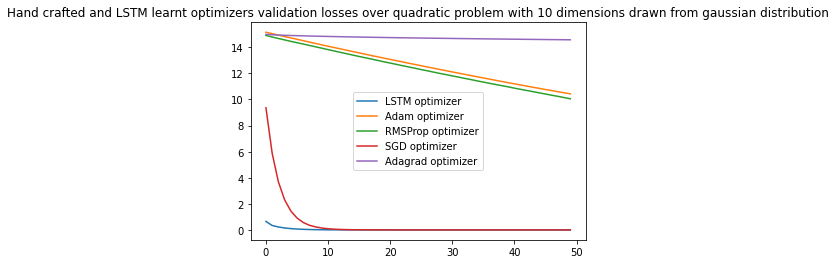

In [115]:
# plt.plot(model.training_losses)
plt.plot(model.validation_losses, label='LSTM optimizer')
plt.plot(adam_history.history['val_loss'], label='Adam optimizer')
plt.plot(rms_prop_history.history['val_loss'], label='RMSProp optimizer')
plt.plot(sgd_history.history['val_loss'], label='SGD optimizer')
plt.plot(adagrad_history.history['val_loss'], label='Adagrad optimizer')

plt.title('Hand crafted and LSTM learnt optimizers validation losses over quadratic problem with 10 dimensions drawn from gaussian distribution')
# show a legend on the plot
plt.legend()

### Accuracy score on unseen test data

In [118]:
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)

In [119]:
adam_preds = adam_model(test_x)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [120]:
lstm_optimizer_preds = tf.reshape(lstm_optimizer_preds, test_y.shape)
adam_preds = tf.reshape(adam_preds, test_y.shape)
rms_preds = tf.reshape(rms_preds, test_y.shape)
adagrad_preds = tf.reshape(adagrad_preds, test_y.shape)

In [121]:
def print_accuracy_metrics(optimizer_name, test_y, preds):
    print(f"*****{optimizer_name} Accuracy metrics******")
    print("Mean absolute error =", round(sm.mean_absolute_error(test_y, preds), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(test_y, preds), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(test_y, preds), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(test_y, preds), 2)) 
    print("R2 score =", round(sm.r2_score(test_y, preds), 2))
    print()

In [122]:
def create_df_for_metrics(optimizer_name, test_y, preds):
    data = {
      "Mean Absolute Error": [round(sm.mean_absolute_error(test_y, preds), 2)],
      "Mean Squared Error": [round(sm.mean_squared_error(test_y, preds), 2)],
      "Median Absolut Error": [round(sm.median_absolute_error(test_y, preds), 2)],
      "Explain variance score": [round(sm.explained_variance_score(test_y, preds), 2)],
      "R2 score": [round(sm.r2_score(test_y, preds), 2)]
    }
    
    df = pd.DataFrame(data, index=[optimizer_name])
    return(df)

In [123]:
def display_accuracy_metrics():
    df_lstm = create_df_for_metrics("LSTM_optimizer", tf.squeeze(test_y), tf.squeeze(lstm_optimizer_preds))
    df_adagrad = create_df_for_metrics("Adagrad", tf.squeeze(test_y), tf.squeeze(adagrad_preds))
    df_rms = create_df_for_metrics("RMSProp", tf.squeeze(test_y), tf.squeeze(rms_preds))
    df_adam = create_df_for_metrics("ADAM", tf.squeeze(test_y), tf.squeeze(adam_preds))
    df_sgd = create_df_for_metrics("SGD", tf.squeeze(test_y), tf.squeeze(sgd_preds))
    df = df_lstm.append([df_adagrad, df_rms, df_adam, df_sgd])
    return df

In [124]:
display_accuracy_metrics()

,Mean Absolute Error,Mean Squared Error,Median Absolut Error,Explain variance score,R2 score
LSTM_optimizer,0.09,0.01,0.07,1.00,1.00
Adagrad,2.65,10.13,2.37,0.06,-0.27
RMSProp,2.17,6.90,1.95,0.32,0.13
ADAM,2.21,7.18,1.97,0.30,0.10
SGD,0.09,0.01,0.07,1.00,1.00


In [125]:
print_accuracy_metrics("LSTM_optimizer", test_y, lstm_optimizer_preds)
print_accuracy_metrics("Adagrad", test_y, adagrad_preds)
print_accuracy_metrics("RMSProp", test_y, rms_preds)
print_accuracy_metrics("ADAM", test_y, adam_preds)

*****LSTM_optimizer Accuracy metrics******
Mean absolute error = 0.09
Mean squared error = 0.01
Median absolute error = 0.07
Explain variance score = 1.0
R2 score = 1.0

*****Adagrad Accuracy metrics******
Mean absolute error = 2.65
Mean squared error = 10.13
Median absolute error = 2.37
Explain variance score = 0.06
R2 score = -0.27

*****RMSProp Accuracy metrics******
Mean absolute error = 2.17
Mean squared error = 6.9
Median absolute error = 1.95
Explain variance score = 0.32
R2 score = 0.13

*****ADAM Accuracy metrics******
Mean absolute error = 2.21
Mean squared error = 7.18
Median absolute error = 1.97
Explain variance score = 0.3
R2 score = 0.1

